<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# Creating DTC-Glaciers EO-DT-Enhanced Data cubes (L2)

If required, install the DTCG API using the following command:

```
!pip install 'dtcg[jupyter] @ git+https://github.com/DTC-Glaciers/dtcg'
```

Run this command in a notebook cell.

In [1]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt

import dtcg.integration.oggm_bindings as oggm_bindings
import dtcg.integration.calibration as calibration

For this example, we focus on the **Brúarjökull outlet glacier** in Vatnajökull, Iceland.
This glacier feeds into **Iceland's largest hydropower system**, making it a relevant site for studying how variations in **glacier mass balance** affect **water availability**.

In this notebook, we use **Brúarjökull** to explore how we can use **L1** data cube **observational data** (created in [this notebook](ADD_LINK)) in the **DTC-Glaciers assimilation pipeline** and to generate **L2** data cubes with associated uncertainties. By integrating new EO observations into modelling frameworks, we can ultimately improve **predictions of future glacier change** and **water availability**, supporting better planning for Iceland's renewable energy resources.

In [2]:
rgi_id_ice = "RGI60-06.00377"  # Brúarjökull
dtcg_oggm_ice = oggm_bindings.BindingsOggmModel(rgi_id=rgi_id_ice)

def get_l1_data_tree(rgi_id):
    l1_datacube_url = "https://cluster.klima.uni-bremen.de/~dtcg/datacubes_case_study_regions/L1/"
    return xr.open_datatree(f"{l1_datacube_url}{rgi_id}.zarr",
                            engine="zarr",
        )

data_tree_ice = get_l1_data_tree(rgi_id_ice)
data_tree_ice

<xarray.DataTree>
Group: /
└── Group: /L1
        Dimensions:                                  (y: 370, x: 436, t: 173, t_wgms: 32)
        Coordinates:
          * y                                        (y) float32 1kB 7.201e+06 ... 7....
          * x                                        (x) float32 2kB 3.94e+05 ... 4.8...
          * t                                        (t) datetime64[ns] 1kB 2011-01-1...
          * t_wgms                                   (t_wgms) int64 256B 1993 ... 2024
        Data variables: (12/21)
            consensus_ice_thickness                  (y, x) float32 645kB ...
            eolis_elevation_change_sigma_timeseries  (t) float64 1kB ...
            eolis_elevation_change_timeseries        (t) float64 1kB ...
            eolis_gridded_elevation_change           (t, y, x) float64 223MB ...
            eolis_gridded_elevation_change_sigma     (t, y, x) float64 223MB ...
            glacier_ext                              (y, x) int8 161kB ...
            ...                                       ...
            spatial_ref                              int64 8B ...
            topo                                     (y, x) float32 645kB ...
            topo_smoothed                            (y, x) float32 645kB ...
            topo_valid_mask                          (y, x) int8 161kB ...
            wgms_mb                                  (t_wgms) float64 256B ...
            wgms_mb_unc                              (t_wgms) float64 256B ...
        Attributes:
            Conventions:         CF-1.12
            comment:             The DTC Glaciers project is developed under the Euro...
            date_created:        2026-01-08T16:09:18.274413
            RGI-ID:              RGI60-06.00377
            glacier_attributes:  {'rgi_id': 'RGI60-06.00377', 'glims_id': 'G343733E64...
            title:               Datacube of glacier-domain variables.
            summary:             Resampled glacier-domain variables from multiple sou...

## Assimilate EO-data within DTC-Glaciers

### Prepare data from L1 for assimilation

Here we showcase how to use observations from **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** and **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** data for creating two different versions of **L2** data cubes. The default approach of OGGM is to use glacier integrated values of **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** over a 20 year period.

To mimic this data, we convert the CryoSat-2 elevation-change time series ($\Delta h$) into mass change over a chosen period ($\mathrm{dmda}$), then compare with the geodetic reference from Hugonnet et al. (2021) retrieved from the [OGGM shop](https://docs.oggm.org/en/stable/shop.html).

**Steps**

1. **Compute mean elevation change per square meter over the period**  

   $$
      \Delta h = h(t_{\mathrm{end}}) - h(t_{\mathrm{start}})
   $$

2. **Convert to kg per square meter** (to match Hugonnet units) using a bulk density $\rho = 850\ \mathrm{kg\,m^{-3}}$:

   $$
      \mathrm{dmda}\;[\mathrm{kg\,m^{-2}}]
      = \Delta h\,\rho
   $$

**TODO**: ADD statement about uncertainty calculation

Let's compare the two datasets using DTC-Glaciers `get_ref_mb` method:

In [3]:
# we will use the L1 datacubes for the calculation of the reference mass balance

calibrator = calibration.CalibratorCryotempo(l1_datacube=data_tree_ice['L1'].ds,
                                             gdir=dtcg_oggm_ice.gdir)

ref_mb_cryotempo = calibrator.get_ref_mb(source="CryoTEMPO-EOLIS",
                                         ref_mb_period="2011-01-01_2019-12-01",)

ref_mb_hugonnet = calibrator.get_ref_mb(source="Hugonnet",
                                        ref_mb_period="2010-01-01_2020-01-01",)

In [4]:
ref_mb_cryotempo

(np.float64(-436.9847817296471),
 'kg m-2',
 np.float64(802.6070245693753),
 '2011-01-15_2019-12-15')

In [5]:
ref_mb_hugonnet

(-505.29999999999995, 'kg m-2 yr-1', 105.5, '2010-01-01_2020-01-01')

Hugonnet et al. (2021) is way more negative than CryoTEMPO-EOLIS. Be aware that Hugonnet et al. (2021) is given in `kg m-2 yr-1`, while CryoTEMPO-EOLIS is given in `kg m-2`.

### Climate forcing data from DestinE Platform

For the climate forcing of the model we use **ERA5** downloaded from the **[Earth Data Hub](https://earthdatahub.destine.eu/)** available on the **[DestinE Platform](https://platform.destine.eu/)**. This allows us to retrive up to date climate data and provide **L2** data cubes up to date. At the current implementation of precomputed Data cubes we stopped processing the data with October 2025, but those easily could be updated as shown below.

For the below code to work you need to register on the **DestinE Platfrom** following this [introductions](https://earthdatahub.destine.eu/getting-started).

In [6]:
# uncomment to get up-to-date climate data for one glacier
#import xarray as xr

#ds = xr.open_dataset(
#    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr",
#    storage_options={"client_kwargs":{"trust_env":True}},
#    chunks={},
#    engine="zarr",
#)

## grid point used by OGGM for Hintereisferner
#ds_hef = ds[['t2m', 'tp']].sel(longitude=10.75, latitude=46.75).load()

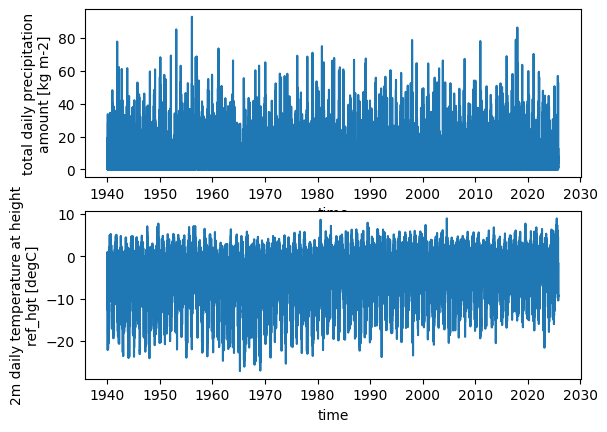

In [7]:
# Or have a look at our downloaded and processed daily data up to October 2025
fp_daily = dtcg_oggm_ice.gdir.get_filepath('climate_historical', filesuffix='_era_daily')

with xr.open_dataset(fp_daily) as ds_clim_daily:
    ds_clim_daily = ds_clim_daily.load()

fig, axs = plt.subplots(2, 1)
ds_clim_daily.prcp.plot(ax=axs[0])
ds_clim_daily.temp.plot(ax=axs[1]);

### Data assimilation and error propagation with Monte Carlo Simulation

For the propagation of **model and observation uncertainty** through the **assimilation pipeline** we conduct a **Monte Carlo Simulation (MCS)**. Our goal is to calibarate a temperature index mass balance model to match one of the above explained EO-data.

For this, we define **parameter distributions** for all **inputs** during model calibration, including the **EO data** and **model parameters** (precipitation factor, temperature bias and degree day factor), creating a **hyperspace of calibration inputs**. From this hyperspace a **sample of around 100 members** is drawn using Saltelli’s extension ([Saltelli 2002](https://doi.org/10.1016/s0010-4655(02)00280-1)) of the Sobel’ sequence ([Sobel′ 2001](https://doi.org/10.1016/s0378-4754(00)00270-6)). The Sobol′ sequence is a popular quasi-random low-discrepancy sequence used to generate uniform samples of parameter space. For this we rely internally on the **[Sensitivity Analysis Lirary SALib](https://salib.readthedocs.io/en/latest/)**.

For **each sample** member we generate the **L2** data cubes and condence their **output** by calculating **quantiles** 0.05, 0.15, 0.25, 0.5 (median), 0.75, 0.85 and 0.95. The final **L2** data cubes contain those quantiles (in the `member` coordinate) as well as a **control run**, which is the result of only using the most likely values of all inputs.

### Conduct assimilation and generate L2 data cubes

For the assimilation we need to select a reference dataset, a reference period and a mass balance model. The current default of **OGGM** is a **monthly temperature index model** `MonthlyTIModel` ([see Documentation of OGGM v1.6.2](https://docs.oggm.org/en/v1.6.2/mass-balance-monthly.html)). As part of DTC-Glaciers we developed a **daily version** `DailyTIModel` as well as a new mass blance model including a **bucket system for snow tracking** `SfcTypeTIModel`. Both of this new models build upon [Schuster et al. 2023](https://doi.org/10.1017/aog.2023.57) and the [OGGM Mass-Balance sandbox](https://github.com/OGGM/massbalance-sandbox).

If you are interested in how to use the new surface tracking mass balance model, expand the cell below for an example. However, this is currently still under development and results should be taken with caution!

In [8]:
from oggm.core import massbalance
from functools import partial

MySfcTypeTIModel = partial(
    massbalance.SfcTypeTIModel,
    mb_model_class=massbalance.DailyTIModel,  # options MonthlyTIModel, DailyTIModel
    climate_resolution='daily',  # how often the climate should be applied, options annual, monthly and daily
    aging_frequency='monthly',  # how often the buckets getting older, options annual and monthly
    ys=2000,  # this defines the year of where we start computing the buckets
    spinup_years=6,  # this defines how many buckets we are using and how we create the buckets for ys
    store_buckets=False,  # if you want to save buckets on the way, available with .mb_buckets_stored, options annual, monthly, daily
    store_buckets_dates=None,  # if you only save buckets at specific dates you can provide a list here in floating year convention
    use_previous_mbs=True,  # when setting this to True you can revisit an already calculated mb value
    store_snowline=True,
)

For our assimilation example, we define in a **calibration matrix** two calibration runs of the same mass balance model (`DailyTIModel`), each paired with a different **reference dataset** and **time window**:

- **Daily_Hugonnet_2010_2020**: calibrate with the geodetic mass balance from **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** over **2010-2020**.  
- **Daily_Cryosat_2011_2020**: calibrate with **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** over **2011–2020**.  

Then `calibrator.calibrate()` runs the assimilation for all entries in the matrix and creates corresponding **L2** data cubes.

In [9]:
from oggm.core import massbalance

calibrator.set_model_matrix(
    name=f"Daily_Hugonnet_2010_2020",
    model=massbalance.DailyTIModel,
    ref_mb_period="2010-01-01_2020-01-01",
    source="Hugonnet",
)

calibrator.set_model_matrix(
    name=f"Daily_Cryosat_2011_2020",
    model=massbalance.DailyTIModel,
    ref_mb_period="2011-01-01_2019-12-01",
    source="CryoTEMPO-EOLIS",
    extra_kwargs={},
)

# run calibration and generate L2 datacubes
l2_datacubes = calibrator.calibrate(
    gdir=dtcg_oggm_ice.gdir,
    # show some information during the workflow to see what is going on
    show_log=True,
    # 'nr_samples' defines the ensemble size for the Monte Carlo Simulation,
    # for demonstration we set it to 2**1, 
    mcs_sampling_settings={'nr_samples': 2**1},
    # select the output data needed, here we select all available data
    datacubes_requested=['monthly', 'annual_hydro', 'daily_smb'],
)

  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]

Daily_Hugonnet_2010_2020_2010-01-01_2020-01-01:
  Starting Monte Carlo Simulation for 12 ensemble members.
  Finished Monte Carlo Simulation: 12 ensemble members for output aggregation available.
  Start generating datacubes
    Start generation of monthly datacube
    Finished generation of monthly datacube
    Start generation of annual_hydro datacube
    Finished generation of annual_hydro datacube
    Start generation of daily_smb datacube


 50%|███████████████████████████████████████████████▌                                               | 1/2 [00:38<00:38, 38.47s/it]

    Finished generation of daily_smb datacube
  Finished generating datacubes

Daily_Cryosat_2011_2020_2011-01-01_2019-12-01:
  Starting Monte Carlo Simulation for 12 ensemble members.
  Finished Monte Carlo Simulation: 12 ensemble members for output aggregation available.
  Start generating datacubes
    Start generation of monthly datacube
    Finished generation of monthly datacube
    Start generation of annual_hydro datacube
    Finished generation of annual_hydro datacube
    Start generation of daily_smb datacube


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:27<00:00, 43.85s/it]

    Finished generation of daily_smb datacube
  Finished generating datacubes



### Add L2 data cubes to our GeoZarr data cube

We can use the same `GeoZarrHandler` as used for the **L1** data cubes in [this notebook](01_L1_datacubes.ipynb) to add the newly created **L2** data cubes and apply the **[CF Convention](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.pdf)** for variable names and metadata.

We can just add the **L2** data cubes one after another to the data tree using the `add_layer` functionality:

In [10]:
from dtcg.datacube.geozarr import GeoZarrHandler

datacube_handler = GeoZarrHandler(data_tree_ice['L1'].ds)

for datacube_name in l2_datacubes:
    datacube_handler.add_layer(datacubes=l2_datacubes[datacube_name], 
                               datacube_name=datacube_name)

datacube_handler.data_tree

<xarray.DataTree>
Group: /
├── Group: /L1
│       Dimensions:                                  (y: 370, x: 436, t: 173, t_wgms: 32)
│       Coordinates:
│         * y                                        (y) float32 1kB 7.201e+06 ... 7....
│         * x                                        (x) float32 2kB 3.94e+05 ... 4.8...
│         * t                                        (t) datetime64[ns] 1kB 2011-01-1...
│         * t_wgms                                   (t_wgms) int64 256B 1993 ... 2024
│       Data variables: (12/21)
│           consensus_ice_thickness                  (y, x) float32 645kB ...
│           eolis_elevation_change_sigma_timeseries  (t) float64 1kB 0.8922 ... 1.059
│           eolis_elevation_change_timeseries        (t) float64 1kB 0.01408 ... -0.1402
│           eolis_gridded_elevation_change           (t, y, x) float64 223MB ...
│           eolis_gridded_elevation_change_sigma     (t, y, x) float64 223MB ...
│           glacier_ext                              (y, x) int8 161kB ...
│           ...                                       ...
│           spatial_ref                              int64 8B ...
│           topo                                     (y, x) float32 645kB ...
│           topo_smoothed                            (y, x) float32 645kB ...
│           topo_valid_mask                          (y, x) int8 161kB ...
│           wgms_mb                                  (t_wgms) float64 256B ...
│           wgms_mb_unc                              (t_wgms) float64 256B ...
│       Attributes:
│           Conventions:         CF-1.12
│           comment:             The DTC Glaciers project is developed under the Euro...
│           date_created:        2026-01-10T21:51:12.899728
│           RGI-ID:              RGI60-06.00377
│           glacier_attributes:  {'rgi_id': 'RGI60-06.00377', 'glims_id': 'G343733E64...
│           title:               Datacube of glacier-domain variables.
│           summary:             Resampled glacier-domain variables from multiple sou...
├── Group: /L2_Daily_Hugonnet_2010_2020
│   ├── Group: /L2_Daily_Hugonnet_2010_2020/monthly
│   │       Dimensions:                   (member: 8, time: 310, rgi_id: 1)
│   │       Coordinates:
│   │         * member                    (member) object 64B 'Control' '0.05' ... '0.95'
│   │         * time                      (time) float64 2kB 2e+03 2e+03 ... 2.026e+03
│   │         * rgi_id                    (rgi_id) <U14 56B 'RGI60-06.00377'
│   │           hydro_year                (time) int64 2kB 2000 2000 2000 ... 2025 2025 2026
│   │           hydro_month               (time) int64 2kB 4 5 6 7 8 9 10 ... 8 9 10 11 12 1
│   │           calendar_year             (time) int64 2kB 2000 2000 2000 ... 2025 2025 2025
│   │           calendar_month            (time) int64 2kB 1 2 3 4 5 6 7 ... 4 5 6 7 8 9 10
│   │       Data variables:
│   │           volume                    (member, time, rgi_id) float64 20kB 6.159e+11 ....
│   │           area                      (member, time, rgi_id) float64 20kB 1.429e+09 ....
│   │           length                    (member, time, rgi_id) float64 20kB 5.44e+04 .....
│   │           specific_mb               (member, time, rgi_id) float64 20kB 96.75 ... -...
│   │           specific_mb_calendar_cum  (member, time, rgi_id) float64 20kB 96.75 ... -...
│   │       Attributes:
│   │           Conventions:           CF-1.12
│   │           comment:               The DTC Glaciers project is developed under the Eu...
│   │           date_created:          2026-01-10T21:51:12.904449
│   │           RGI-ID:                RGI60-06.00377
│   │           glacier_attributes:    {}
│   │           title:                 Datacube of observation-informed modelled variables.
│   │           summary:               Observation-informed modelled variables for RGI6-I...
│   │           calibration_strategy:  OGGM mass-balance model 'DailyTIModel' calibrated ...
│   ├── Group: /L2_Daily_Hugonnet_20

## Explore L2 data cubes

<div class="alert alert-danger">
    <b>IMPORTANT</b>: Note that the L2 data cubes generated in this notebook use a smaller number of ensemble for the Monte Carlo Simulation, theirfore uncertainties are not compareable with the preprocessed L2 data cubes. Theirfore we load the equivalent preprocessed data cubes as generated above. Uncomment the next cell if you are really want to look at the datacubes generated above.
</div>

In [17]:
def get_l2_data_tree(rgi_id):
    l2_datacube_url = "https://cluster.klima.uni-bremen.de/~dtcg/datacubes_case_study_regions/L1_and_L2/"
    return xr.open_datatree(
            f"{l2_datacube_url}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )
datacube_handler = GeoZarrHandler(data_tree=get_l2_data_tree(rgi_id_ice))

After the generation of the **L2** data cubes and adding them to the data tree let's explore them. In general their are three datasets avaiable per **L2** data cube: `'monthly'`, `'annual_hydro'` and `'daily_smb'`. They containe different data in different temporal resolutions.

Let's have a look at the monthly volume evolution of our two realisations:

In [18]:
datacube_handler.data_tree['L2_Daily_Hugonnet_2010_2020']['monthly']

<xarray.DataTree 'monthly'>
Group: /L2_Daily_Hugonnet_2010_2020/monthly
    Dimensions:                   (member: 8, time: 310, rgi_id: 1)
    Coordinates:
      * member                    (member) <U7 224B 'Control' '0.05' ... '0.95'
      * time                      (time) float64 2kB 2e+03 2e+03 ... 2.026e+03
      * rgi_id                    (rgi_id) <U14 56B 'RGI60-06.00377'
        calendar_month            (time) int64 2kB dask.array<chunksize=(310,), meta=np.ndarray>
        calendar_year             (time) int64 2kB dask.array<chunksize=(310,), meta=np.ndarray>
        hydro_month               (time) int64 2kB dask.array<chunksize=(310,), meta=np.ndarray>
        hydro_year                (time) int64 2kB dask.array<chunksize=(310,), meta=np.ndarray>
    Data variables:
        area                      (member, time, rgi_id) float64 20kB dask.array<chunksize=(1, 310, 1), meta=np.ndarray>
        length                    (member, time, rgi_id) float64 20kB dask.array<chunksize=(1, 310, 1), meta=np.ndarray>
        specific_mb               (member, time, rgi_id) float64 20kB dask.array<chunksize=(1, 310, 1), meta=np.ndarray>
        specific_mb_calendar_cum  (member, time, rgi_id) float64 20kB dask.array<chunksize=(1, 310, 1), meta=np.ndarray>
        volume                    (member, time, rgi_id) float64 20kB dask.array<chunksize=(1, 310, 1), meta=np.ndarray>
    Attributes:
        Conventions:           CF-1.12
        comment:               The DTC Glaciers project is developed under the Eu...
        date_created:          2026-01-09T09:22:59.484987
        RGI-ID:                RGI60-06.00377
        glacier_attributes:    {}
        title:                 Datacube of observation-informed modelled variables.
        summary:               Observation-informed modelled variables for RGI6-I...
        calibration_strategy:  OGGM mass-balance model 'DailyTIModel' calibrated ...

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_quantile_bands(ds, x_dim, y_var, y_scaling, ax=None, color="C0",
                        alpha=(0.3, 0.2, 0.1), label="median",):

    x = ds[x_dim]
    # plot quantile bands
    bands = [(0.25, 0.75, alpha[0]),
             (0.15, 0.85, alpha[1]),
             (0.05, 0.95, alpha[2]),]
    for q_low, q_high, a in bands:
        ax.fill_between(x,
                        ds[y_var].sel(member=str(q_low)).isel(rgi_id=0) * y_scaling,
                        ds[y_var].sel(member=str(q_high)).isel(rgi_id=0) * y_scaling,
                        color=color, alpha=a, linewidth=0, )

    # Median line
    ax.plot(x, ds[y_var].sel(member='0.5') * y_scaling,
            color=color, label=label,)

    

    return ax

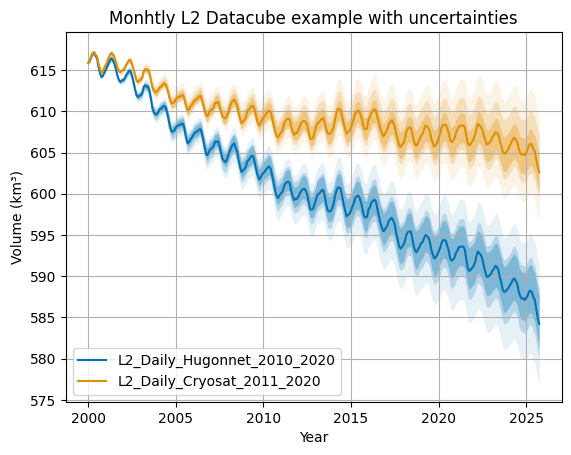

In [20]:
colors = sns.color_palette('colorblind')

fig, ax = plt.subplots()
for L2_name, c in zip(['L2_Daily_Hugonnet_2010_2020', 'L2_Daily_Cryosat_2011_2020'], colors):
    plot_quantile_bands(datacube_handler.data_tree[L2_name]['monthly'],
                        'time', 'volume', 1e-9,
                        ax=ax, label=L2_name, color=c)
ax.legend()
ax.grid('on')
ax.set_ylabel('Volume (km³)')
ax.set_xlabel('Year')
ax.set_title('Monhtly L2 Datacube example with uncertainties')
plt.show()

The **shaded areas** correspond to the **quantile bands** (0.25, 0.75),(0.15, 0.85) and (0.05, 0.95), representing 50%, 70% and 90% of the ensemble outputs of the **MCS**.

We also can look at glacier runoff at annual or monthly resolution:

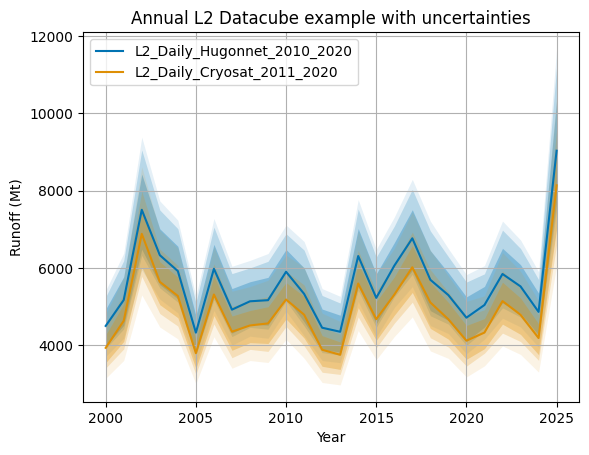

In [21]:
fig, ax = plt.subplots()
for L2_name, c in zip(['L2_Daily_Hugonnet_2010_2020', 'L2_Daily_Cryosat_2011_2020'], colors):
    plot_quantile_bands(datacube_handler.data_tree[L2_name]['annual_hydro'],
                        'time', 'runoff', 1e-9,
                        ax=ax, label=L2_name, color=c)

ax.legend()
ax.grid('on')
ax.set_ylabel('Runoff (Mt)')
ax.set_xlabel('Year')
ax.set_title('Annual L2 Datacube example with uncertainties')
plt.show()

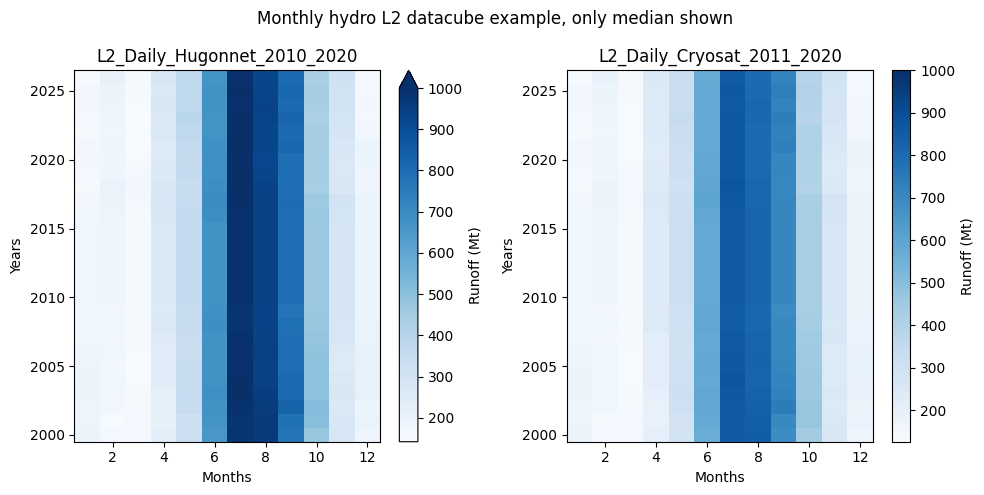

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, L2_name in zip(axs, ['L2_Daily_Hugonnet_2010_2020', 'L2_Daily_Cryosat_2011_2020']):
    monthly_runoff = datacube_handler.data_tree[L2_name]['annual_hydro'].runoff_monthly.sel(member='0.5')
    monthly_runoff = monthly_runoff.rolling(time=31, center=True, min_periods=1).mean() * 1e-9
    monthly_runoff.clip(0).plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'Runoff (Mt)',}, vmax=1000)
    ax.set_title(L2_name)
    ax.set_xlabel('Months')
    ax.set_ylabel('Years')
plt.suptitle('Monthly hydro L2 datacube example, only median shown')
plt.tight_layout()

### Precomputed L2 data cubes

We prepared preprocessed **L2** data cubes for our case study regions in **Iceland** and **Austria** (see [this notebook](01_L1_datacubes.ipynb#Preprocessed-data-cubes-for-case-study-regions) for an overview of available glaciers). Those preprocessed **L2** data cubes as well as the corresponding **L1** data cubes are saved as **GeoZarr** and can be accessed with the following function, using the RGI v6 ID of a glacier as input:

In [16]:
def get_l2_data_tree(rgi_id):
    l2_datacube_url = "https://cluster.klima.uni-bremen.de/~dtcg/datacubes_case_study_regions/L1_and_L2/"
    return xr.open_datatree(
            f"{l2_datacube_url}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )